In [1]:
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split

from math import sqrt
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use ('seaborn-whitegrid')
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from arch import arch_model
import pandas_datareader.data as web
from datetime import datetime, timedelta

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df = pd.read_csv('AirPassengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
train_data , test_data = train_test_split(df, test_size=0.3, shuffle = False)

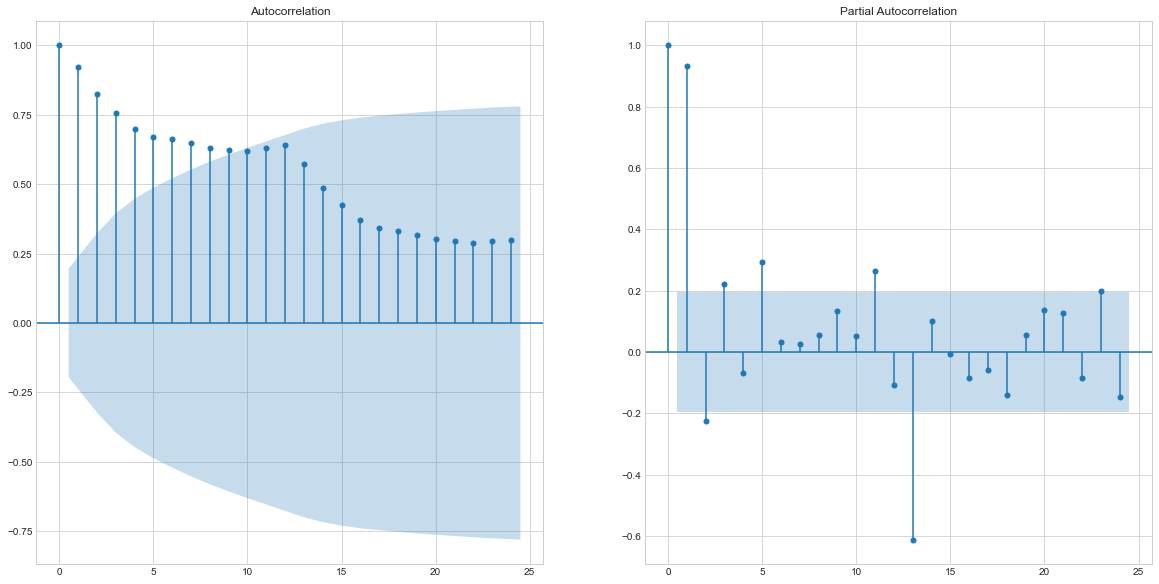

In [5]:
###################################
############ARIMA#################
##################################


#ACF / PACF

fig, ax = plt.subplots(1,2, figsize=(20,10))
sm.graphics.tsa.plot_acf(train_data.values.squeeze(),lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),lags=24, ax=ax[1]);

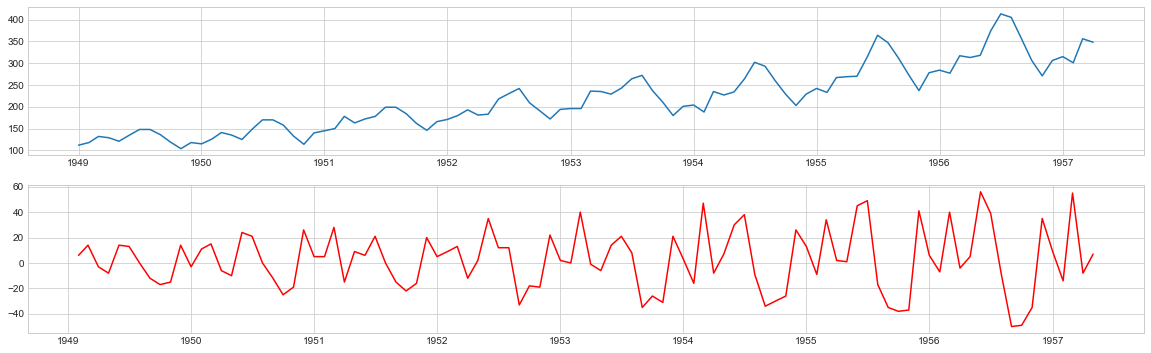

In [6]:
# Differencing

diff_data = df.diff().dropna()
train_diff_data, test_diff_data = train_test_split(diff_data, test_size=0.3, shuffle = False)

plt.figure(figsize=(20,6))
plt.subplot(211)
plt.plot(train_data)
plt.subplot(212)
plt.plot(train_diff_data, color ='r')

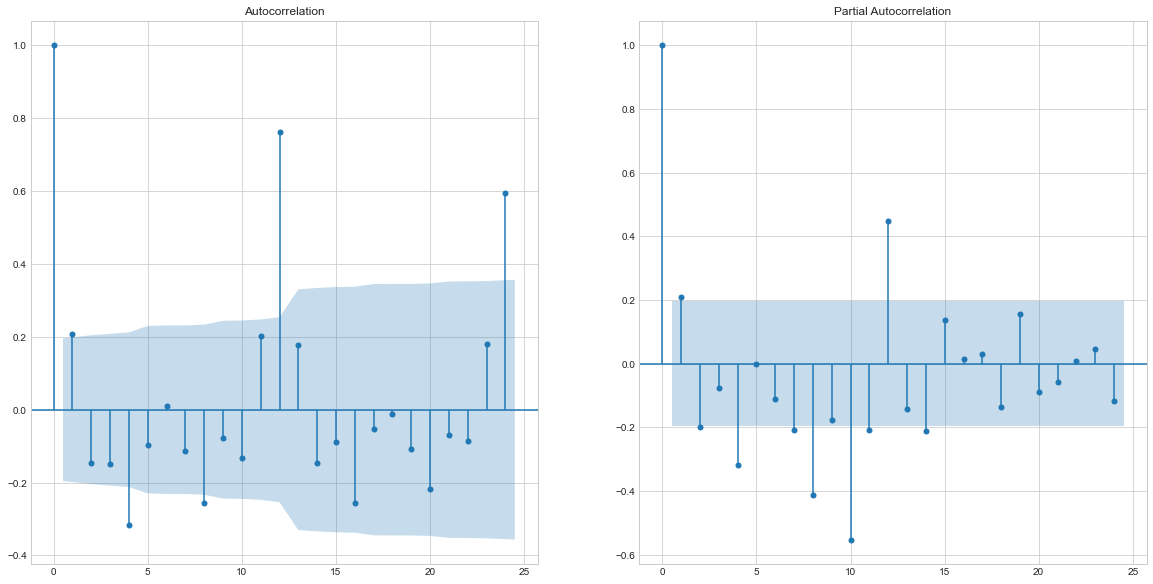

In [18]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sm.graphics.tsa.plot_acf(train_diff_data.values.squeeze(),lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_diff_data.values.squeeze(),lags=24, ax=ax[1], method='ywm');

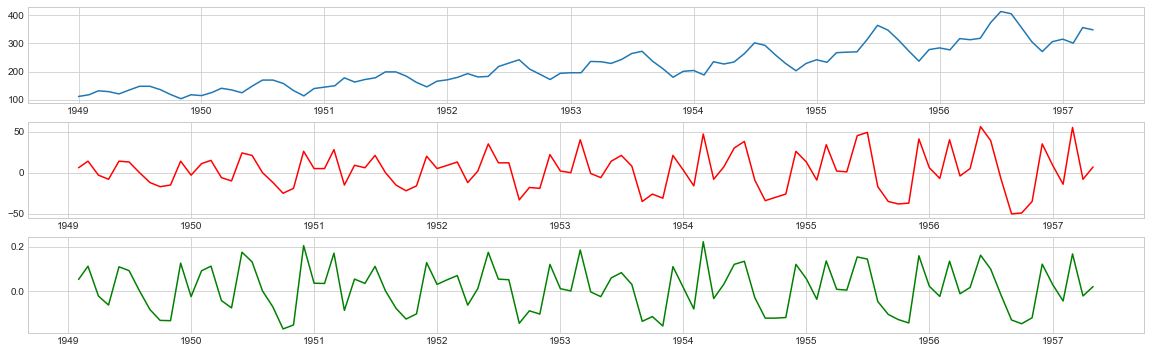

In [19]:
log_diff_data = np.log(df).diff().dropna()
train_log_diff_data, test_log_diff_data = train_test_split(log_diff_data, test_size=0.3, shuffle=False)

plt.figure(figsize=(20,6))
plt.subplot(311)
plt.plot(train_data)
plt.subplot(312)
plt.plot(train_diff_data, color ='r')
plt.subplot(313)
plt.plot(train_log_diff_data, color='g')

In [20]:
# ADF

res_adf_raw = adfuller(train_data['#Passengers'])
res_adf_diff = adfuller(train_diff_data['#Passengers'])
res_adf_log = adfuller(train_log_diff_data['#Passengers'])
print('ADF P-Value for raw : %f' %res_adf_raw[1])
print('ADF P-Vlaue for diff : %f' %res_adf_diff[1])
print('ADF P-Vlaue for log : %f' %res_adf_log[1])

ADF P-Value for raw : 0.997560
ADF P-Vlaue for diff : 0.197102
ADF P-Vlaue for log : 0.068250


In [21]:
res_arima = auto_arima(train_data, seasonal= False,
                      start_p=1, max_p=12, start_q=12, max_q=12,
                      trace=True, error_action='ignore',
                      suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=909.769, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=904.979, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.370, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=900.136, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=904.858, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=906.463, Time=0.05 sec


In [22]:
pred_arima = res_arima.predict(len(test_data), return_conf_int=True)
pred_arima_value = pred_arima[0]
pred_arima_ub = pred_arima[1][:,0]
pred_arima_lb = pred_arima[1][:,1]
pred_arima_idx = list(test_data.index)
rmse_arima = sqrt(mean_squared_error(test_data, pred_arima_value))

rmse_arima

79.95190197363614

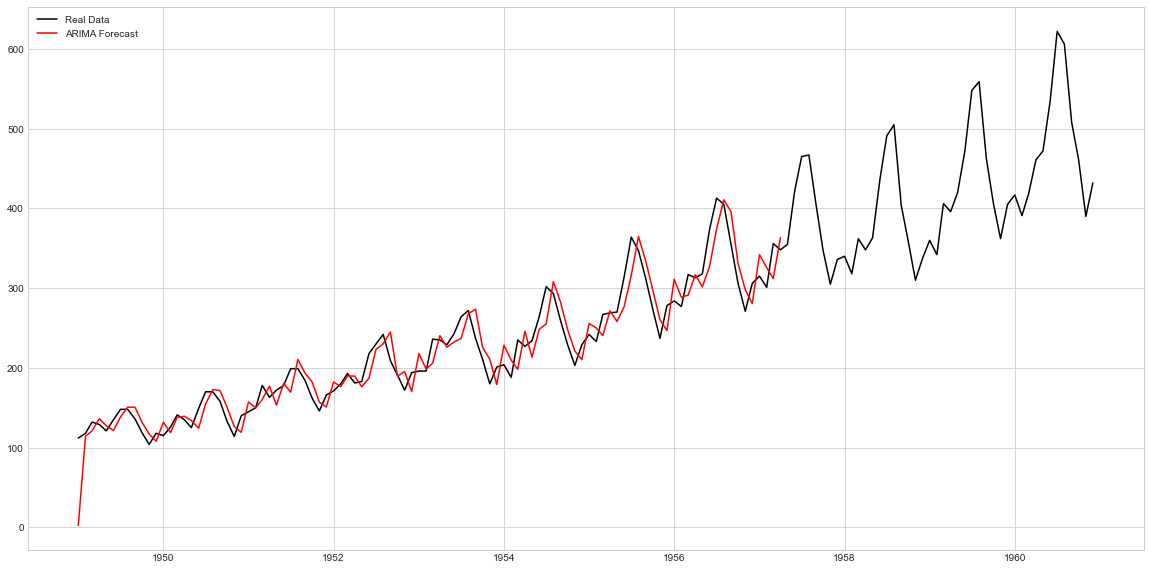

In [23]:
### (0,t) 시점에서 t+1 시점 예측 ( 예측한 점을 계속 input data 로 사용)

fit_arima_value_tbl =pd.DataFrame(res_arima.predict_in_sample(), index=train_data.index)

plt.figure(figsize=(20,10))
plt.plot(df,label='Real Data', color='k')
plt.plot(fit_arima_value_tbl, label='ARIMA Forecast', color='r')
plt.legend(loc='upper left')
plt.show()

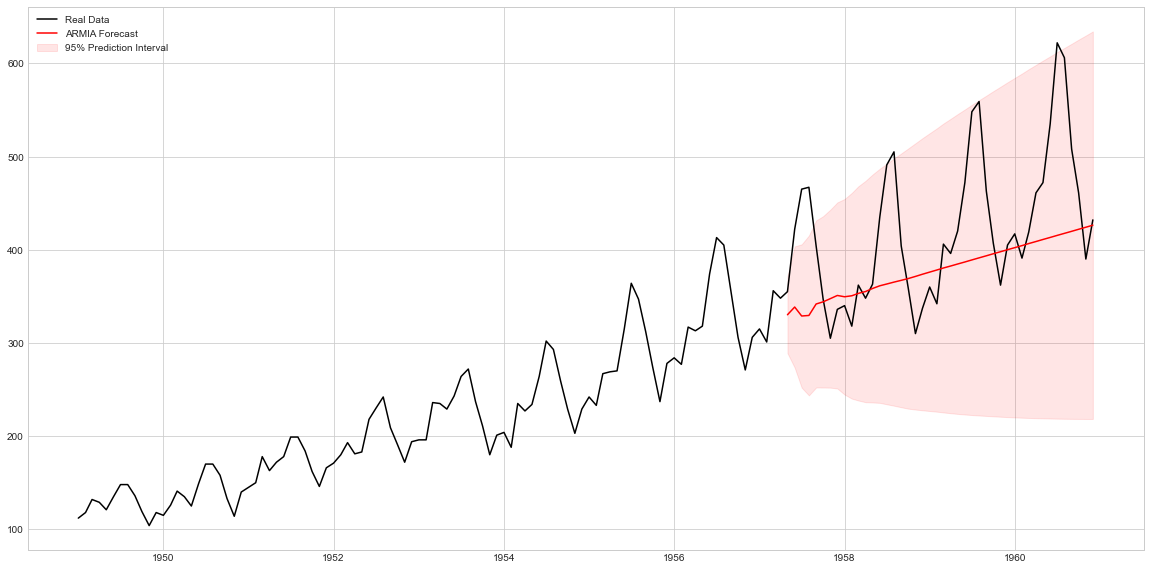

In [24]:
### train_data로 test_data 구간 예측

pred_arima_value_tbl = pd.DataFrame(pred_arima_value, index=test_data.index)

plt.figure(figsize=(20,10))
plt.plot(df, label='Real Data', color='k')
plt.plot(pred_arima_value_tbl, label='ARMIA Forecast', color='r')
plt.fill_between(pred_arima_idx, pred_arima_lb, pred_arima_ub, color='r', alpha = 0.1, label = '95% Prediction Interval')
plt.legend(loc='upper left')
plt.show()

In [25]:
###################################
############SARIMA################
##################################

res_sarima = auto_arima(train_data, seasonal= True,m=12,
                      start_p=1, max_p=12, start_q=1, max_q=12,
                      start_P=1, max_P=12, start_Q=1, max_Q=12,
                      trace=True, error_action='ignore',
                      suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=647.214, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=649.032, Time=0.12 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=648.826, Time=0.26 sec
 ARIMA(0,1,0)(0,1,4)[12]             : AIC=649.169, Time=0.54 sec
 ARIMA(0,1,0)(0,1,5)[12]             : AIC=inf, Time=2.85 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=649.130, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(1,1,4)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=648.848, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=650.694, Time=0.22 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(3,1,0)[12]          

Total fit time: 48.410 seconds


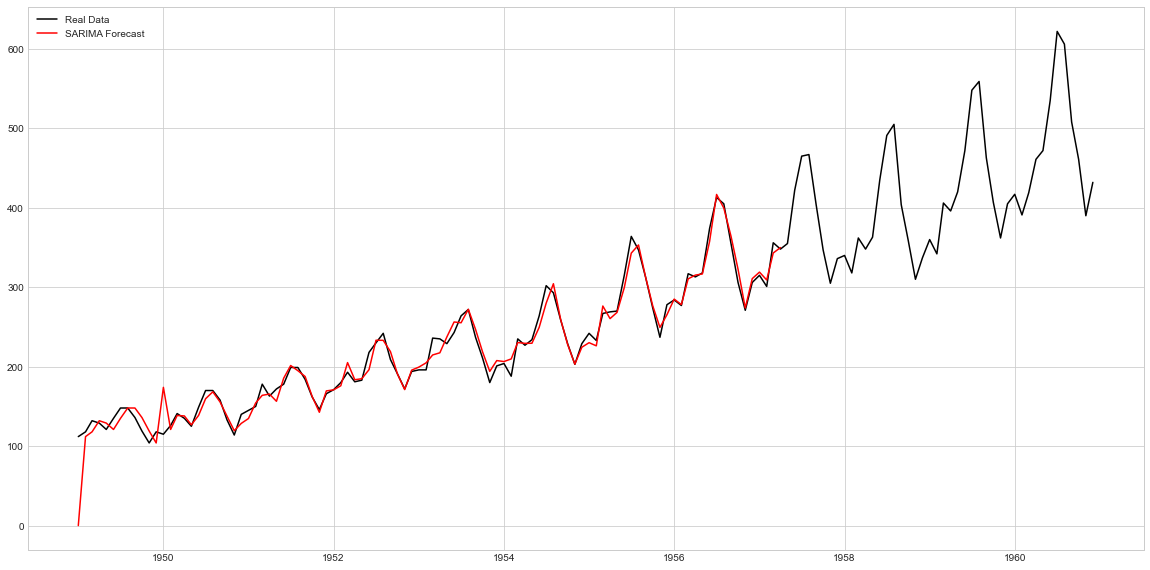

In [26]:
#(0,t) 시점에서 t+1 시점 예측 ( 예측한 점을 계속 input data 로 사용)

fit_sarima_value_tbl =pd.DataFrame(res_sarima.predict_in_sample(), index=train_data.index)

plt.figure(figsize=(20,10))
plt.plot(df,label='Real Data', color='k')
plt.plot(fit_sarima_value_tbl, label='SARIMA Forecast', color='r')
plt.legend(loc='upper left')
plt.show()

In [27]:
pred_sarima = res_sarima.predict(len(test_data), return_conf_int=True)
pred_sarima_value = pred_sarima[0]
pred_sarima_ub = pred_sarima[1][:,0]
pred_sarima_lb = pred_sarima[1][:,1]
pred_sarima_idx = list(test_data.index)
rmse_sarima = sqrt(mean_squared_error(test_data, pred_sarima_value))

rmse_sarima

26.094047739542056

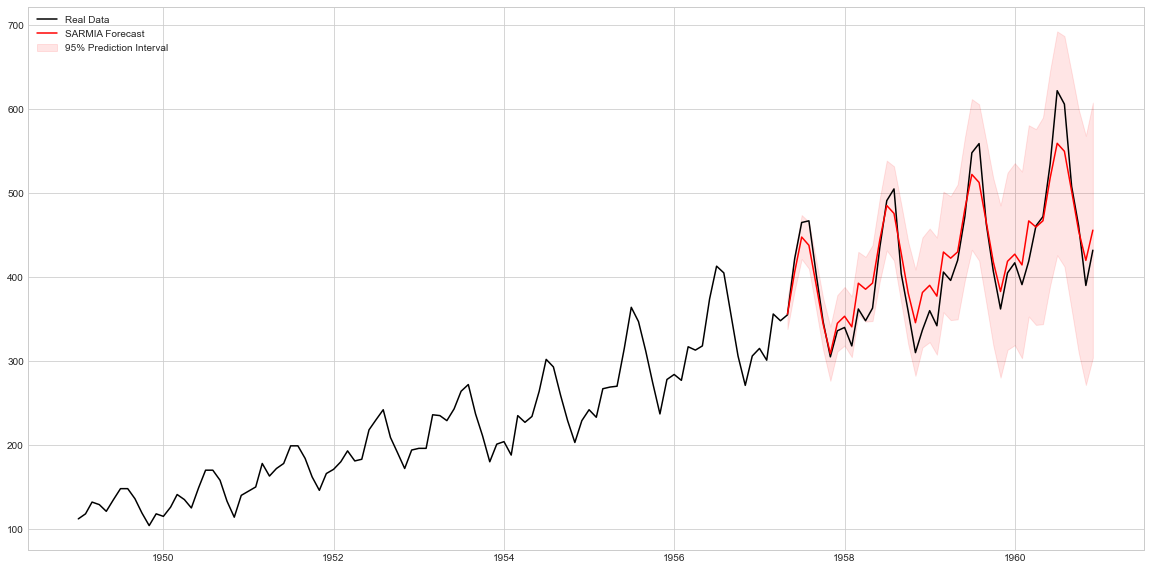

In [28]:
pred_sarima_value_tbl = pd.DataFrame(pred_sarima_value, index=test_data.index)

plt.figure(figsize=(20,10))
plt.plot(df, label='Real Data', color='k')
plt.plot(pred_sarima_value_tbl, label='SARMIA Forecast', color='r')
plt.fill_between(pred_sarima_idx, pred_sarima_lb, pred_sarima_ub, color='r', alpha = 0.1, label = '95% Prediction Interval')
plt.legend(loc='upper left')
plt.show()